In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from skimage import io
import os
import cv2
from tqdm import tqdm
import random
import torch
from torchvision.transforms.functional import to_pil_image

HELLO


In [2]:
# read dataframe

os.chdir(r'C:\WORKS\Master_Thesis\DeepGlobeDataset\archive')

train = pd.read_csv(os.path.join(os.getcwd(), 'metadata.csv'))
test = train[train['split'] == 'test']
val = train[train['split'] == 'val']
train = train[train['split'] == 'train']


# size of file
train.shape

(6226, 4)

#### Utils

In [3]:
# plots mask image
def show_mask(masks, figsize=(10, 10)):
    f, axarr = plt.subplots(figsize=figsize)
    axarr.imshow(masks, cmap='gray')


def show_rgb_image(rgb_image, figsize=(10, 10)):
    f, axarr = plt.subplots(figsize=figsize)
    axarr.imshow(rgb_image)


def plot_images(**image_cmap_pairs):
    """PLot images in one row
    """
    n = len(image_cmap_pairs)
    plt.figure(figsize=(16, 5))
    for i, (name, image_cmap) in enumerate(image_cmap_pairs.items()):
        image, cmap = image_cmap
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')))
        plt.imshow(image, cmap=cmap)
    plt.tight_layout()
    plt.show()

#### Mask Preprocessing Functions

In [4]:
# create boundary from existing mask
def create_boundary(mask: np.array, boundary_width_pixel: int) :
    # create kernel to erode mask 
    kernel = np.ones((boundary_width_pixel, boundary_width_pixel), np.uint8)
    body = cv2.erode(mask, kernel, iterations=1)
    # create boundary
    boundary = mask - body

    return boundary

# combine boundary and footprints
def combine_boundary_footprints(boundary, footprints):
    # create a mask filled with zeros with the same shape as the footprints
    combined_mask = np.zeros_like(footprints)
    # where values are greater than zero in the footprints replace them with 1 in the combined_mask
    combined_mask[footprints > 0] = 1
    # where values are greater than zero in the footprints replace them with 2 in the combined_mask
    combined_mask[boundary > 0] = 2

    return combined_mask 



def save_combined_mask(mask_path:str, folder:str):
    footprints = io.imread(os.path.join(os.getcwd(), mask_path))
    # pass the footprints to create boundary function
    boundary = create_boundary(footprints, boundary_width_pixel=4) 
    # pass the boundary to create a combined footprints and boundary mask
    combined_mask = combine_boundary_footprints(boundary, footprints)

        
    combined_mask_color = np.zeros((footprints.shape[0], footprints.shape[1], 3), dtype=np.uint8)

    # Set each channel separately
    combined_mask_color = np.where(combined_mask == 0, [0, 0, 0], combined_mask_color) # CHANNEL 0: BACKGROUND
    combined_mask_color = np.where(combined_mask == 1, [0, 255, 0], combined_mask_color)  # CHANNEL 1: FOOTPRINTS
    combined_mask_color = np.where(combined_mask == 2, [0, 0, 255], combined_mask_color)  # CHANNEL 2: BOUNDARY

    # get mask name from mask path
    mask_name = mask_path.split('/')[-1].split('.')[0]
    # save to folder
    file_dir = os.path.join(folder, mask_name + '_combined.png')
    cv2.imwrite(file_dir, combined_mask_color)


#### Implementation of Mask Preprocessing - for a single mask

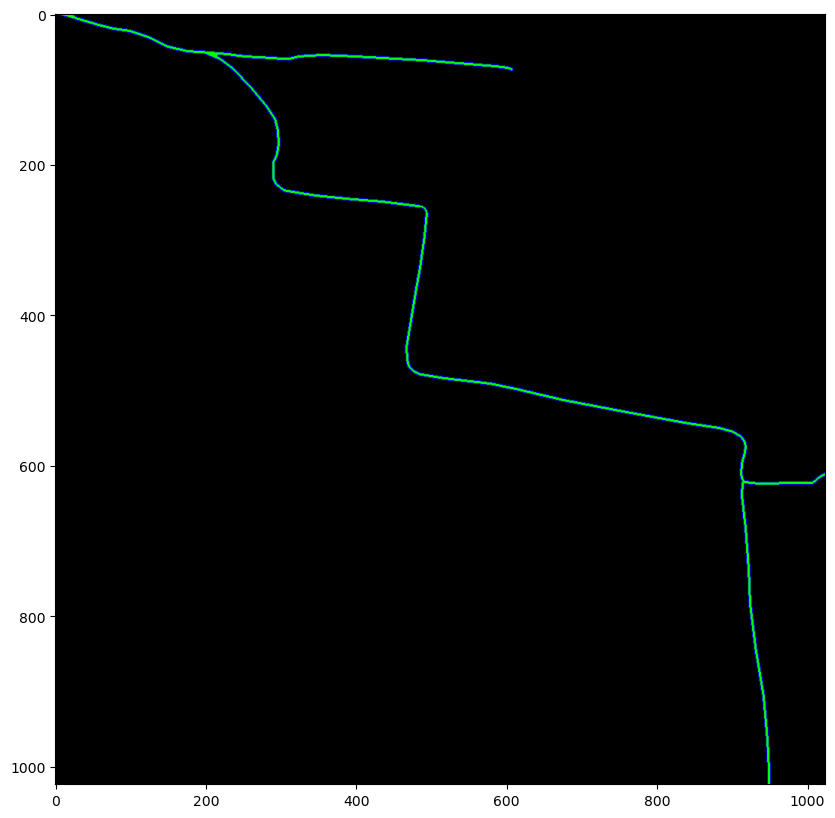

In [5]:
mask_name = '27718_mask.png'

footprints = io.imread(os.path.join(os.getcwd(), 'train', '27718_mask.png'))

boundary = create_boundary(footprints, boundary_width_pixel=3) 
combined_mask = combine_boundary_footprints(boundary, footprints)

combined_mask_color = np.zeros((footprints.shape[0], footprints.shape[1], 3), dtype=np.uint8)

# Set each channel separately
combined_mask_color = np.where(combined_mask == 0, [0, 0, 0], combined_mask_color)
combined_mask_color = np.where(combined_mask == 1, [0, 255, 0], combined_mask_color)  # Channel 1: Footprints (red)
combined_mask_color = np.where(combined_mask == 2, [0, 0, 255], combined_mask_color)  # Channel 2: Boundary (green)
show_rgb_image(combined_mask_color)

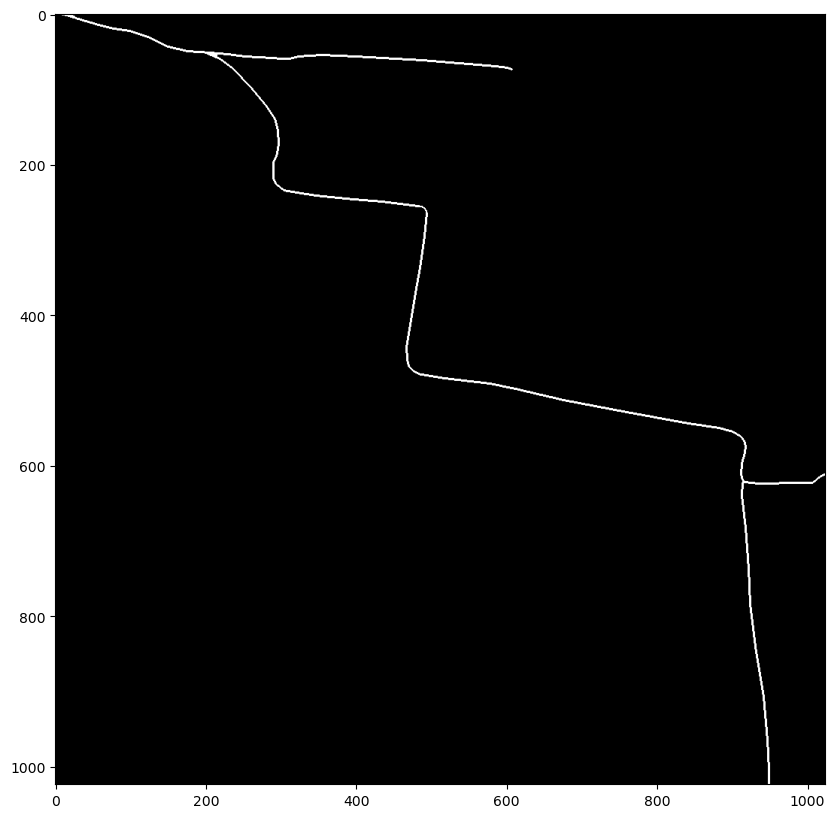

In [6]:
show_mask(combined_mask_color[:, :, 1])

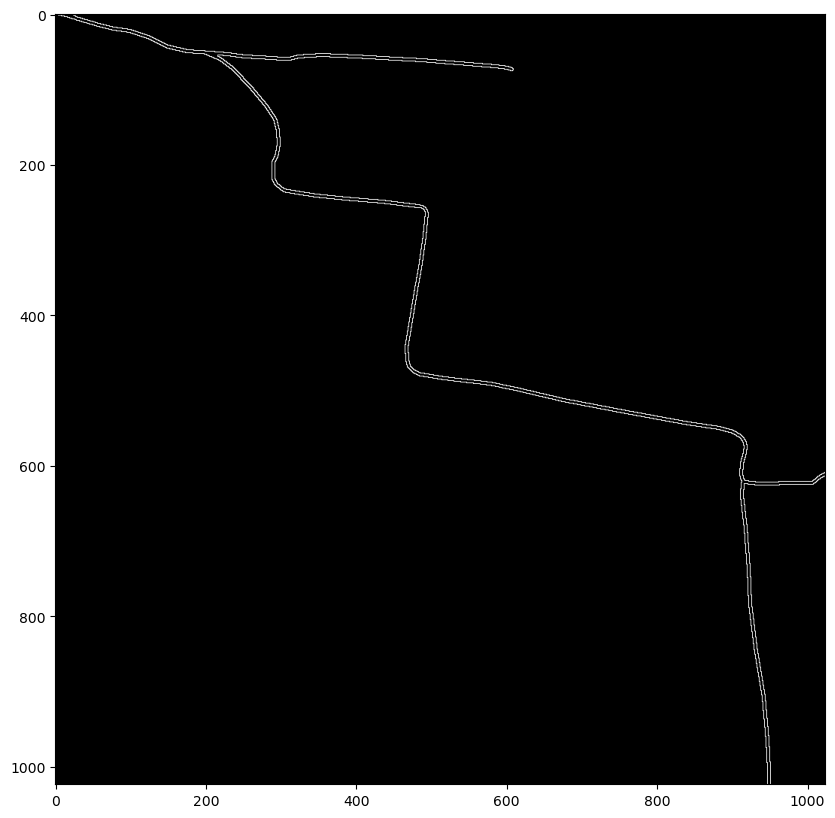

In [7]:
show_mask(combined_mask_color[:, :, 2])

#### Implementation of Mask Preprocessing - for all masks

In [8]:
# implement function
# all_mask_paths = train['mask_path'].tolist()
# folder = r'C:\WORKS\Master_Thesis\DeepGlobeDataset\archive\combined_masks'
# for path in tqdm(all_mask_paths):
#     save_combined_mask(path, folder)

#### Custom Mean and Standard Deviation for Image

In [9]:
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

In [10]:
transformation = A.Compose([
    ToTensorV2()
])


class DeepGlobeMeanStd(torch.utils.data.Dataset):
    
    def __init__(
        self,
        data_list,
        image_dir,
        transform=None
    ):
        # transformation
        self.transform = transform
        # generate full path to image file
        self.image_paths = []
        for data in data_list:
            self.image_paths.append(os.path.join(image_dir, data))

    def __getitem__(self, i):
        image = cv2.imread(self.image_paths[i])
        
        if self.transform:
            sample = self.transform(image=image)
            image = sample['image']
        
        return image
    
    def __len__(self):
        return len(self.image_paths)

In [52]:
images_folder = r'C:\WORKS\Master_Thesis\DeepGlobeDataset\archive'
images_path_list = train['sat_image_path'].unique().tolist()

ImageDataset = DeepGlobeMeanStd(images_path_list, 
                                images_folder,
                                transform=transformation)

ImageDataloader = torch.utils.data.DataLoader(
    ImageDataset,
    batch_size = 2,
    shuffle=False,
)

In [49]:
image = ImageDataset.__getitem__(1)
image.shape

torch.Size([3, 1024, 1024])

In [ ]:
# from PIL import ImageStat
# from operator import add
# statistics = None

# class Stats(ImageStat.Stat):
#     def __add__(self, other):
#         return Stats(list(map(add, self.h, other.h)))

# statistics = None
# for data in ImageDataloader:
#     for b in range(data.shape[0]):
#         if statistics is None:
#             statistics = Stats(to_pil_image(data[b]))
#         else:
#             statistics += Stats(to_pil_image(data[b]))

In [ ]:
# img_mean = [73.47118156177608, 97.62286006787794, 104.47535231777452]
# img_std = [31.260341853724455, 32.30159190196031, 39.849960372653]

In [68]:
def get_mean_std(loader):
    # Compute the mean and standard deviation of all pixels in the dataset
    num_pixels = 0
    mean = 0
    std = torch.zeros(3)
    for images in loader:
        batch_size, num_channels, height, width = images.shape
        num_pixels += batch_size * height * width
        mean += images.mean(axis=(0, 2, 3), dtype=torch.float32).sum()
        # std += images.std(axis=(0, 2, 3), dtype=torch.float32).sum()

    mean /= num_pixels
    # std /= num_pixels

    return mean

In [69]:
batch_size = 32
mean = get_mean_std(ImageDataloader)

In [67]:
mean

tensor([0.0001, 0.0001, 0.0001])